In [1]:
import tensorflow as tf

keras = tf.keras
import pandas as pd, numpy as np
import os, unidecode, glob
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from pylab import rcParams
rcParams['figure.figsize'] = (15, 8)

In [2]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [3]:
check_df = pd.concat([pd.read_parquet(f) for f in glob.glob(os.getcwd()+'/filtered_data/checkin/*.parquet')], ignore_index=True)

check_df['date'] = check_df.date.apply(lambda x: x.split(','))
check_df = check_df.explode('date').reset_index().drop('index',axis=1)
check_df['date'] = pd.to_datetime(check_df.date)

In [4]:
bus_df = pd.concat([pd.read_parquet(f) for f in glob.glob(os.getcwd()+'/filtered_data/business/*.parquet')], ignore_index=True)

bus_df['city'] = bus_df.city.apply(lambda x: unidecode.unidecode(x))
bus_df['state'] = np.select(
    [
        bus_df['city'].isin(['Toronto', 'Richmond Hill', 'Scarborough', 'Markham', 'Mississauga', 'Brampton', 'Vaughan', 'North York']),
        bus_df['city'].isin(['Calgary']),
        bus_df['city'].isin(['Montreal']),
    ],
    [
        'ON',
        'AB',
        'QC'
    ]
)

In [5]:
df = bus_df[['business_id','city']].merge(check_df,on=['business_id'],how='inner')
df['city'] = df.city.astype('category')
df = df.assign(date=df.date.dt.round('H'))
df.head()

,business_id,city,date
0,EosRKXIGeSWFYWwpkbhNnA,Toronto,2012-06-12 19:00:00
1,EosRKXIGeSWFYWwpkbhNnA,Toronto,2013-02-11 15:00:00
2,EosRKXIGeSWFYWwpkbhNnA,Toronto,2013-02-22 18:00:00
3,EosRKXIGeSWFYWwpkbhNnA,Toronto,2013-03-05 21:00:00
4,EosRKXIGeSWFYWwpkbhNnA,Toronto,2013-03-06 17:00:00


In [6]:
pivot_df = df.pivot_table(index='date',values='business_id',columns='city',aggfunc='count', fill_value=0)
pivot_df.index = pd.DatetimeIndex(pivot_df.index)
pivot_df

city,Brampton,Calgary,Markham,Mississauga,Montreal,North York,Richmond Hill,Scarborough,Toronto,Vaughan
date,,,,,,,,,,
2010-01-16 02:00:00,0,1,0,0,0,0,0,0,0,0
2010-01-16 05:00:00,0,0,0,0,0,0,0,0,1,0
2010-01-16 10:00:00,0,0,0,0,0,0,0,0,2,0
2010-01-16 13:00:00,0,0,0,0,0,0,0,0,1,0
2010-01-16 15:00:00,0,1,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...
2019-12-13 13:00:00,0,0,0,0,0,1,1,0,4,0
2019-12-13 14:00:00,0,0,0,0,0,0,1,0,4,0
2019-12-13 15:00:00,0,0,3,1,2,0,0,0,5,0


In [7]:
daily_tor = pivot_df.loc[:,'Toronto'].resample('D').sum().reset_index().rename(columns={'date':'ds','Toronto':'y'}).set_index('ds')

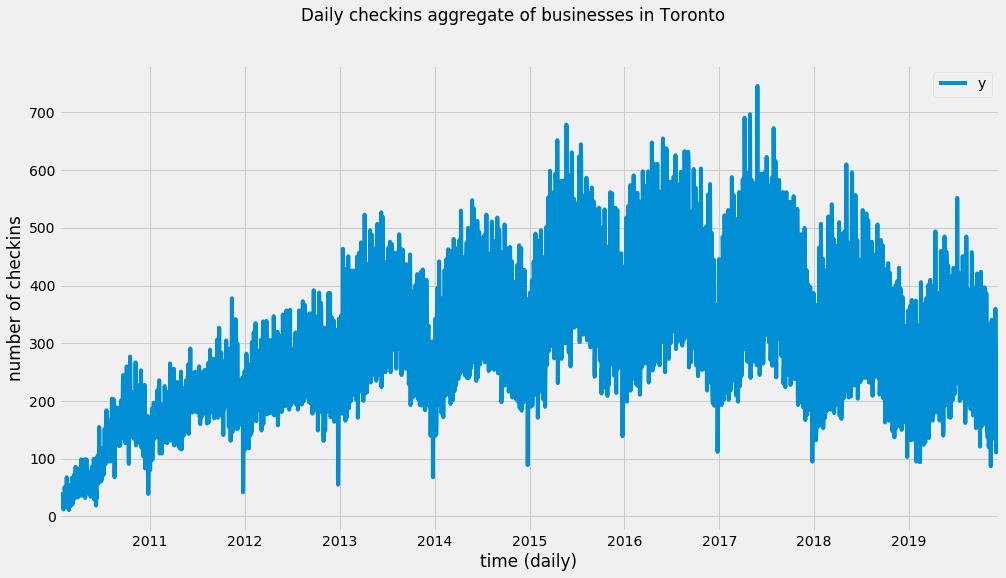

In [8]:
fig, ax = plt.subplots()
daily_tor.plot(ax=ax)
fig.suptitle('Daily checkins aggregate of businesses in Toronto')
ax.set(xlabel='time (daily)',ylabel=('number of checkins'))
plt.legend()
plt.show()

In [9]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [34]:
def train_test_split(ts_df):
    test_split = '2019-01-01'
    train = ts_df.loc[ts_df.index < test_split].copy()
    test = ts_df.loc[(ts_df.index >= test_split)].copy()
    print(train.shape)
    print(test.shape)
    return (train,test)

d_train, d_test = train_test_split(daily_tor)
error_vals = list()

(3272, 1)
(347, 1)


## Linear Model

In [37]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 14
train_set = window_dataset(d_train[:-d_test.shape[0]].y, window_size)
valid_set = window_dataset(d_train[-d_test.shape[0]:].y, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=15)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
91/91 [==============================] - 1s 11ms/step - loss: 153.9968 - mae: 154.5229 - val_loss: 53.0214 - val_mae: 54.1583
Epoch 2/500
91/91 [==============================] - 0s 5ms/step - loss: 44.6188 - mae: 45.1177 - val_loss: 45.1846 - val_mae: 45.6931
Epoch 3/500
91/91 [==============================] - 0s 5ms/step - loss: 40.3296 - mae: 40.8211 - val_loss: 45.6181 - val_mae: 46.8042
Epoch 4/500
91/91 [==============================] - 0s 5ms/step - loss: 37.3055 - mae: 37.8003 - val_loss: 40.4430 - val_mae: 40.3665
Epoch 5/500
91/91 [==============================] - 0s 5ms/step - loss: 35.3154 - mae: 35.8060 - val_loss: 37.9805 - val_mae: 38.2137
Epoch 6/500
91/91 [==============================] - 0s 5ms/step - loss: 34.5838 - mae: 35.0779 - val_loss: 35.9029 - val_mae: 36.6689
Epoch 7/500
91/91 [==============================] - 1s 7ms/step - loss: 33.5334 - mae: 34.0301 - val_loss: 34.7097 - val_mae: 36.0521
Epoch 8/500
91/91 [==============================] -

In [39]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

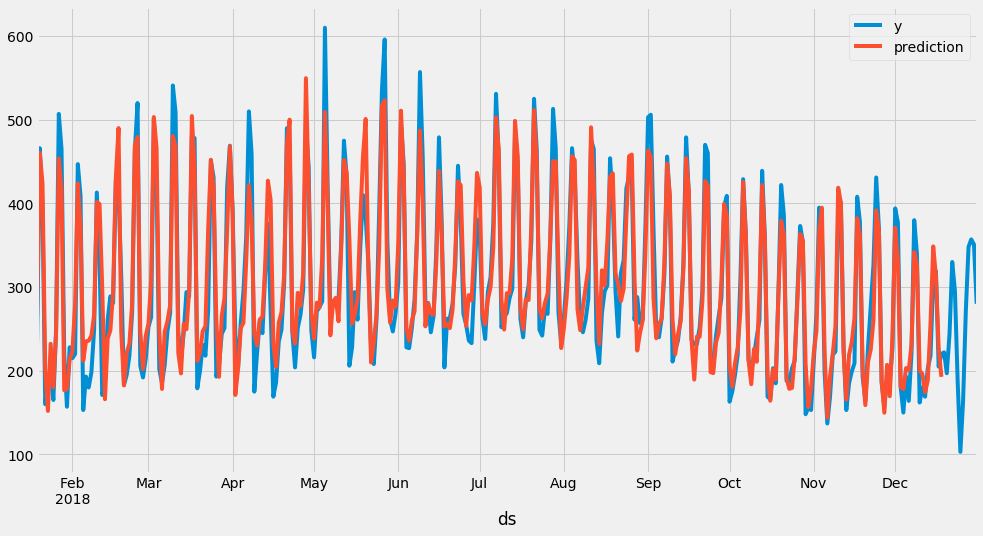

In [51]:
lin_predict = model_forecast(model, d_train[-d_test.shape[0]:].y, window_size)[:, 0]
fig, ax = plt.subplots()
d_train[-d_test.shape[0]:].plot(ax=ax)
pd.DataFrame(lin_predict, index=d_train[-d_test.shape[0]:-d_test.shape[0]+lin_predict.shape[0]].index, columns=['prediction']).plot(ax=ax)

In [52]:
keras.metrics.mean_absolute_error(d_train[-d_test.shape[0]:].y[:lin_predict.shape[0]], lin_predict).numpy()

26.004023

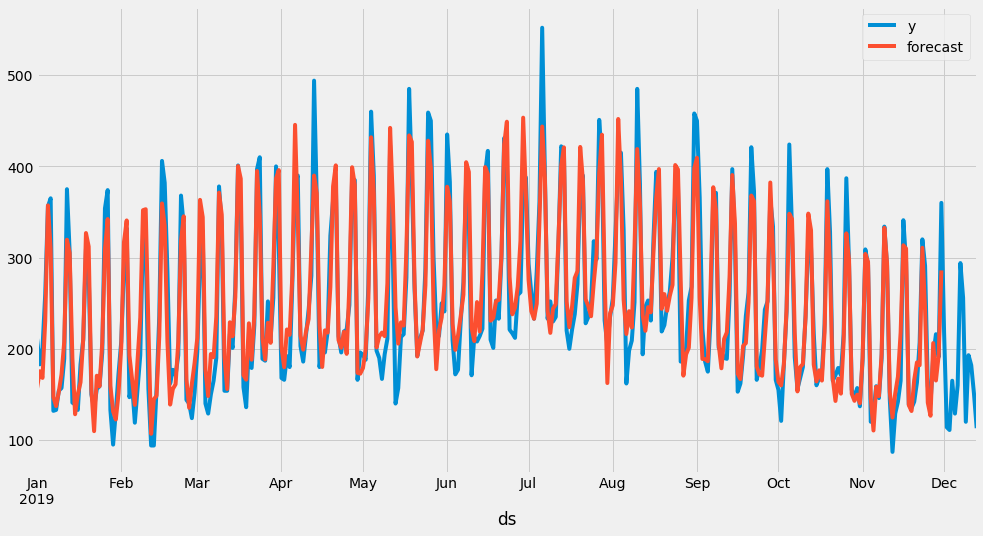

In [54]:
lin_forecast = model_forecast(model, d_test.y, window_size)[:, 0]
fig, ax = plt.subplots()
d_test.plot(ax=ax)
pd.DataFrame(lin_forecast, index=d_test[:lin_forecast.shape[0]].index, columns=['forecast']).plot(ax=ax)

In [55]:
keras.metrics.mean_absolute_error(d_test[:lin_forecast.shape[0]].y, lin_forecast).numpy()

24.355127